<a href="https://colab.research.google.com/github/brunojaime/ambientando_fiestas_coderh/blob/main/ambientandos_fiestas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Ambientando Fiestas
Este notebook está relacionado a la organización Ambientando Fiestas y se divide en dos partes.

- Obtenación de datos:
Tiene como objetivo importar toda la información necesaria para poder hacer un posterior análisis y ciencia de datos de la información obtenida de la organización de eventos Ambientando Fiestas

*Esta sección no podrá ser ejecutada ya que requiere credenciales, sin embargo se ve el paso a paso de su ejecución*
- Exploración de datos
Dedicado al análisis y exploración del conjunto de datos proporcionado mediante la extracción de información de la API de WooCommerce y SharePoints Lists. El objetivo es aplicar metodologías de ciencia de datos para descubrir percepciones, tendencias y patrones que puedan informar los procesos de toma de decisiones.

## IMPORTANTE
Se deben ejecutar las celdas desde el punto 6. Ya que las partes anteriores requieren credenciales (Igualmente, se ve el proceso de obtención de datos)

# 1) Motivación
La motivación de este pryoecto surge de poder utilizar los conocimientos aprendidos en el curso de coder house de ciencia de datos aplicándolo a un caso real obteniendo la información desde diferentes fuentes, lo cual implica una extracción, transformación y carga de los datos (ETL).
Por otro lado, el data set planteado está en constante crecimiento, por lo tanto se espera poder contar con mayores datos a lo largo del tiempo. Esto genera una motivación en poder ver la tendencia de datos a medida que el dataset vaya creciendo

# 2) Objetivos
- Lograr una buena implementación en cuanto a la adquisición de datos de las dos fuentes involucradas: Un e-commerce, datos de la aplicación gestionada internamente
- Data wrangling: Procesar los datos obtenidos. Entender los desafíos que tienen estos datos, incluyendo datos faltantes, datos mal formateados e intentar corregirlos
- Generar distintas respuestas a problemas de negocio: Los datos involucrados pueden responder las distintas inquietudes que tiene la organización, y esto servir para una mejor planificación y organización del negocio
- Generar valor a partir de los datos y poder descubrir información que aún no está siendo analizada

# 3) Negocio: Ambientando Fiestas
Ambientando Fiestas es un modelo de negocio que brinda servicios de decoración de eventos y candy bar.

In [ ]:
#from office365.runtime.auth.client_credential import ClientCredential
#from office365.sharepoint.client_context import ClientContext
# Configuración de SharePoint
#from msal import ConfidentialClientApplication
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 4) Problemas de Negocio

1) ¿Cuánto tiempo antes al día del evento reserva la gente?​
2) Se requieren visualizar cantidad de fiestas por mes​
3) ¿Cómo determino cuál es el momento que más gente necesito contratar?​
4) ¿Cómo determinar cantidad de personal por zona​
5) ¿La gente reincide con la organización? ¿Compra los mismos productos?​

# 5) Obtención y guardado de datos

### Configurando el diccionario de credenciales

In [ ]:
# Las siguientes credenciales fueron guardadas en la máquina personal para poder acceder a las listas de sharepoint mediante Azure Active directory

credentials =  {
"client_id" : "",
"tenant_id" :"",
"client_secret" : "",
"cert_thumbrs" :"",
"private_key" : """
"""
}



<a name='3'></a>
## Configuraciones de sharepoint




In [ ]:
sharepoint_config ={
"tenant" : "https://ambientandofiestas.sharepoint.com" ,
"site" :"Ambientandofiestas"
}

### Guardando credenciales y configuraciones

In [ ]:
# Estee código solo puede ser ejecutado desde la máquina personal

import json
import os

path = "~/.microsoft"

credential_path = {
    "path" :f"{path}/credentials",
    "data": credentials
}
config_path = {
    "path" : f"{path}/sharepoint_settings",
    "data" : sharepoint_config
}

paths = [credential_path,config_path]

for file_path in paths:
    expanded_root = os.path.expanduser(file_path['path'])
    with (open(expanded_root,'w') as file):
        json.dump(file_path['data'],file)



### Obteniendo las credenciales y configuraciones de sharepoint

In [ ]:
# Reading jsons data

#Credentials
expanded_root = os.path.expanduser(credential_path['path'])
with open(expanded_root, 'r') as file:
    credentials_data = json.load(file)
client_id = credentials_data["client_id"]
tenant_id = credentials_data["tenant_id"]
cert_thumbrs = credentials_data["cert_thumbrs"]
private_key = credentials['private_key']

#Sharepoint_config
expanded_root = os.path.expanduser(config_path['path'])
with open(expanded_root, 'r') as file:
    config_data = json.load(file)
tenant = config_data['tenant']
site = config_data['site']



### Getting the token to makes the api calls

In [ ]:
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.backends import default_backend

cert = {
    "private_key" : private_key,
    "thumbprint": cert_thumbrs
}

authority = f"https://login.microsoftonline.com/{tenant_id}"
scope = [f"{tenant}/.default"]  # Adjust the scope to sharepoint

# Create app instance
app = ConfidentialClientApplication(
    client_id,
    authority=authority,
    client_credential=cert
)

# Get token
result = app.acquire_token_for_client(scopes=scope)

if 'access_token' in result:
    token = result['access_token']
    print("Access token: token")
else:
    print("no se pudo")
    print("Falló el acceso a la obtención del tokem. Error:", result.get("error"), result.get("Descripción del error"))

Access token: token


In [ ]:
import requests

headers = {
    "Authorization": f"Bearer {token}",
    "Accept": "application/json;odata=verbose",
    "Content-Type": "application/json",
}
# Sharepoint URL site
site_url = f"{tenant}/sites/{site}"
response = requests.get(site_url,headers)
response

<Response [403]>

In [ ]:
import requests
from typing import List, Dict, Any

class SharePointList:
    def __init__(self, url: str, list_name: str, headers: Dict[str, str]):
        self.site_url = url
        self.name = list_name
        self.headers = headers

    def get_all_items(self, retrieve_all_data: bool = True, fields: List[str] = []) -> List[Any]:
        all_data = []
        api_url = self.site_url
        if fields:
            fields_string = ",".join(fields)
            api_url = f"{api_url}/_api/web/lists/getByTitle('{self.name}')/items?$select={fields_string}"
        else:
            api_url = f"{api_url}/_api/web/lists/getByTitle('{self.name}')/items"

        if retrieve_all_data:
            while api_url:
                response = requests.get(api_url, headers=self.headers)
                if response.status_code == 200:
                    data = response.json()
                    all_data.extend(data['d']['results'])
                    api_url = data['d'].get('__next')
                else:
                    print(f"Error fetching the data {response.status_code}")
                    break
        else:
            response = requests.get(api_url, headers=self.headers)
            if response.status_code == 200:
                data = response.json()
                all_data.extend(data['d']['results'])
            else:
                print(f"Error fetching the data {response.status_code}")

        return all_data


## Obteniendo información

## Sharepoint lists

### Pedidos

In [ ]:
elements = ["Title","Estado","Usuario","Edad","Homenajeado","Tematica","Horario","FinEvento","Lugar","Created"]

pedidos_actuales = SharePointList(url=site_url,list_name="Pedidos",headers=headers)
pedidos_actuales_list = pedidos_actuales.get_all_items(retrieve_all_data=True,fields=elements)
df_pedidos_actuales = pd.DataFrame(pedidos_actuales_list)

pedidos_finalizados = SharePointList(url=site_url,list_name="Pedidos finalizados",headers=headers)
pedidos_finalizados_list = pedidos_finalizados.get_all_items(retrieve_all_data=True,fields=elements)
df_pedidos_finalizados = pd.DataFrame(pedidos_finalizados_list)

df_pedidos_sh= pd.concat([df_pedidos_actuales,df_pedidos_finalizados])

df_pedidos_sh=df_pedidos_sh.drop(["__metadata","Homenajeado"],axis=1)

df_pedidos_sh = df_pedidos_sh.rename(columns={"Horario":"Inicio_evento","FinEvento":"Fin_evento"})

df_pedidos_sh.head()

,Title,Estado,Usuario,Edad,Tematica,Inicio_evento,Fin_evento,Lugar,Created
0,7473,finalizado,Alejandrasarro@gmail.com,6,n/a,2024-05-19T14:23:00Z,2024-05-19T03:00:00Z,SUM,2023-09-08T14:27:24Z
1,8096,confirmado,pcouceiro88@gmail.com,3,No sabemos,2024-05-14T19:30:00Z,2024-05-14T22:00:00Z,Casa,2023-10-31T10:03:25Z
2,8222,completado,bolomariapaz@gmail.com,1,animalitos en safari,2024-06-30T16:00:00Z,2024-06-30T20:00:00Z,Casa,2023-11-08T15:09:40Z
3,8319,confirmado,daia2505@hotmail.com,1,mickey y sus amigos,2024-06-15T03:00:00Z,2024-06-15T03:00:00Z,Salón,2023-11-15T18:21:22Z
4,8584,confirmado,camilatovani52@gmail.com,1,Carrusel,2024-08-06T22:00:00Z,2024-08-07T01:00:00Z,Salón,2023-12-17T19:01:35Z


In [ ]:
df_pedidos_sh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1912 entries, 0 to 1463
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          1912 non-null   object
 1   Estado         1912 non-null   object
 2   Usuario        1909 non-null   object
 3   Edad           1912 non-null   int64 
 4   Tematica       1891 non-null   object
 5   Inicio_evento  1912 non-null   object
 6   Fin_evento     1889 non-null   object
 7   Lugar          1889 non-null   object
 8   Created        1912 non-null   object
dtypes: int64(1), object(8)
memory usage: 149.4+ KB


### Detalle Pedido

In [ ]:
elements = ["id_detalle_pedido","id_pedido","Title","id_producto","Cantidad"]

detalle_pedido_actuales = SharePointList(url=site_url,list_name="Detalle pedido",headers=headers)
detalle_pedido_actuales_list = detalle_pedido_actuales.get_all_items(retrieve_all_data=True,fields=elements)
df_detalle_pedido_actuales = pd.DataFrame(detalle_pedido_actuales_list)

detalle_pedido_finalizado = SharePointList(url=site_url,list_name="Detalle pedido finalizado",headers=headers)
detalle_pedido_finalizado_list = detalle_pedido_finalizado.get_all_items(retrieve_all_data=True,fields=elements)
df_detalle_pedido_finalizado = pd.DataFrame(detalle_pedido_finalizado_list)

df_detalle_pedido= pd.concat([df_detalle_pedido_actuales,df_detalle_pedido_finalizado])
df_detalle_pedido=df_detalle_pedido.drop("__metadata",axis=1)
df_detalle_pedido.head()

,Title,id_producto,id_detalle_pedido,Cantidad,id_pedido
0,6986,5823,3259,1,850
1,6989,2972,3263,1,855
2,7000,2975,3273,1,870
3,7107,5823,3381,1,991
4,7143,2719,3422,1,1046


In [ ]:
df_detalle_pedido.shape


(2769, 5)

### Colaboraciones por pedido

In [ ]:
elements = ["id_colaborador","colaboracion","Title","estado_colaboracion","id_pedido"]

colaboraciones_por_pedido_actual = SharePointList(url=site_url,list_name="Colaboraciones por pedido",headers=headers)
colaboraciones_por_pedido_list = colaboraciones_por_pedido_actual.get_all_items(retrieve_all_data=True,fields=elements)
df_colaboraciones_por_pedido = pd.DataFrame(colaboraciones_por_pedido_list)


colaboraciones_por_pedido_finalizado = SharePointList(url=site_url,list_name="Colaboraciones por pedido finalizados",headers=headers)
colaboraciones_por_pedido_finalizado_list = colaboraciones_por_pedido_finalizado.get_all_items(retrieve_all_data=True,fields=elements)
df_colaboraciones_por_pedido_finalizado = pd.DataFrame(colaboraciones_por_pedido_finalizado_list)
df_colaboraciones_por_pedido = pd.DataFrame()
df_colaboraciones_por_pedido = pd.concat([df_colaboraciones_por_pedido,df_colaboraciones_por_pedido_finalizado])
df_colaboraciones_por_pedido=df_colaboraciones_por_pedido.drop(['__metadata','estado_colaboracion'],axis=1)
df_colaboraciones_por_pedido.head()




,Title,id_colaborador,colaboracion,id_pedido
0,7873,32.0,G,2268
1,7113,28.0,I,2303
2,6935,28.0,I,2335
3,6935,28.0,I,2336
4,7185,28.0,I,2338


## Obteniendo la información desde el e-commerce (woocommerce)

Realizamos la conexión con el e-commerce de la Ambientando Fiestas

In [ ]:
# Las siguientes credenciales fueron guardadas en la máquina personal para poder acceder a la api de woocommerce
credentials ={
"consumer_key":"",
"consumer_secret":""
}

## Guardando credenciales y configuración de woocommerce

In [ ]:
# Estee código solo puede ser ejecutado desde la máquina personal

import json
import os

path = "~/.woocommerce"

credential_path = {
    "path" :f"{path}/credentials",
    "data": credentials
}


paths = [credential_path]

for file_path in paths:
    expanded_root = os.path.expanduser(file_path['path'])
    with (open(expanded_root,'w') as file):
        json.dump(file_path['data'],file)



### Obteniendo las credenciales de woocommerce

In [ ]:
# Reading jsons data

#Credentials
expanded_root = os.path.expanduser(credential_path['path'])
with open(expanded_root, 'r') as file:
    credentials_data = json.load(file)
consumer_key = credentials_data["consumer_key"]
consumer_secret = credentials_data["consumer_secret"]


In [ ]:
from woocommerce import API

wcapi = API(
    url="https://ar.ambientandofiestas.com/",
    consumer_key=consumer_key,
    consumer_secret=consumer_secret,
    version="wc/v3",
    timeout=200
)

Obtener pedidos desde woocommerce

In [ ]:

df_pedidos_wc = pd.DataFrame()
registros_por_pagina = 100


pagina = 1
respuesta = True
# Aumenta el timeout a 30 segundos
while respuesta:
    # Hace la solicitud a la API

    respuesta = wcapi.get("orders", params={"per_page": registros_por_pagina, "page": pagina}).json()
    if not respuesta:
        break

    # Convierte la respuesta en DataFrame y la agrega al DataFrame existente
    df_temp = pd.DataFrame(respuesta)
    df_pedidos_wc = pd.concat([df_pedidos_wc, df_temp], ignore_index=True)

    # Incrementa el número de página
    pagina += 1

# Muestra los primeros registros para verificar



In [ ]:
df_pedidos_wc.head(3)

,id,parent_id,status,currency,version,prices_include_tax,date_created,date_modified,discount_total,discount_tax,...,payment_url,is_editable,needs_payment,needs_processing,date_created_gmt,date_modified_gmt,date_completed_gmt,date_paid_gmt,currency_symbol,_links
0,10112,0,pending,ARS,8.0.1,False,2024-06-24T15:40:13,2024-06-24T15:42:18,1000,0,...,https://ar.ambientandofiestas.com/checkout/ord...,True,True,True,2024-06-24T15:40:13,2024-06-24T15:42:18,None,None,$,{'self': [{'href': 'https://ar.ambientandofies...
1,10111,0,pending,ARS,8.0.1,False,2024-06-24T15:28:51,2024-06-24T15:39:58,0,0,...,https://ar.ambientandofiestas.com/checkout/ord...,True,True,True,2024-06-24T15:28:51,2024-06-24T15:39:58,None,None,$,{'self': [{'href': 'https://ar.ambientandofies...
2,10110,0,on-hold,ARS,8.0.1,False,2024-06-24T15:24:51,2024-06-24T15:24:51,0,0,...,https://ar.ambientandofiestas.com/checkout/ord...,True,False,True,2024-06-24T15:24:51,2024-06-24T15:24:51,None,None,$,{'self': [{'href': 'https://ar.ambientandofies...


La columna billing es una columna del tipo json.

In [ ]:
df_pedidos_wc['billing'].head()

0    {'first_name': 'Rodrigo Diez Ojeda', 'last_nam...
1    {'first_name': 'Florencia Gala', 'last_name': ...
2    {'first_name': 'Geraldine', 'last_name': 'Ricc...
3    {'first_name': 'Florencia Gala', 'last_name': ...
4    {'first_name': 'Nadia Ferros', 'last_name': ''...
Name: billing, dtype: object

Aplicamos una función para poder obtener todas las columnas dentro de la columnas billing

In [ ]:
def getColumnsOfBilling(df_pedidos_woo_commerce):
    billing_list = []

    for item,column in df_pedidos_woo_commerce.iterrows():

        title = f", 'id': '{column['id']}'}}"
        dict =str(column['billing'])[:-1] + title
        billing_list.append(dict)
    return billing_list

In [ ]:
def convert_to_dict(item,index):
    try:
        return json.loads(item)
    except:
        print(f"No se pudo con el item: {index}")
        return False

In [ ]:
billing_list = getColumnsOfBilling(df_pedidos_wc)
id_list = df_pedidos_wc['id'].tolist()
clean_list = [item.replace('\\', '\\\\').replace("'", '"') for item in billing_list]

total_invalid_items = 0
dict = []
for index, item in enumerate(clean_list):
    if(convert_to_dict(item,index)):
        dict.append(convert_to_dict(item,index))
    else:
        total_invalid_items += 1
print(f"Total items no válidos {total_invalid_items}")

df_billings_ = pd.DataFrame(dict)
df_billings_ = df_billings_.rename(columns={'billing_date':'Inicio_evento_wc'})
df_billings_['id'] = df_billings_['id'].astype('Int64')
df_billings_['Inicio_evento_wc'] = pd.to_datetime(df_billings_['Inicio_evento_wc'],utc=True)
#df_billings = df_billings_[['id','Inicio_evento_wc']]
df_billings_.head(3)
df_billings_.info()
df_billings = df_billings_.copy()

No se pudo con el item: 1014
No se pudo con el item: 1235
No se pudo con el item: 1623
No se pudo con el item: 1787
No se pudo con el item: 2281
No se pudo con el item: 2498
No se pudo con el item: 3072
No se pudo con el item: 3158
No se pudo con el item: 3278
No se pudo con el item: 3320
No se pudo con el item: 3352
No se pudo con el item: 3361
Total items no válidos 12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3644 entries, 0 to 3643
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   first_name          3644 non-null   object             
 1   last_name           3644 non-null   object             
 2   company             3644 non-null   object             
 3   address_1           3644 non-null   object             
 4   address_2           3644 non-null   object             
 5   city                3644 non-null   object             
 6   state               3644 n

In [ ]:
df_merge_pedidos = pd.merge(df_pedidos_wc,df_billings,left_on='id',right_on='id',how='inner')
df_woo_commerce_complete = df_merge_pedidos.copy()
df_woo_commerce_complete = df_woo_commerce_complete.rename(columns={"id":"Title"})


In [ ]:
df_pedidos_wc = df_woo_commerce_complete.copy()

Dejamos los datos que nos sirven

In [ ]:
df_pedidos_sh = df_pedidos_sh.drop(columns=['Usuario'],axis=1)

In [ ]:
columns_drop_customer = ['customer_id','customer_ip_address','parent_id','first_name','last_name','company','country','email','phone','billing_first_name','dni']
columns_drop_ship_tax = ['shipping','shipping_total','shipping_tax','cart_tax','total_tax','prices_include_tax','shipping_tax','discount_tax','prices_include_tax','currency','tax_lines','shipping_lines','coupon_lines','refunds','billing','needs_payment']
columns_drop_pedido = ['version','order_key','discount_total','transaction_id','customer_user_agent','cart_hash','number','payment_url','is_editable','needs_processing','_links','line_items','fee_lines','total']
columns_drop_dates = ['date_completed','meta_data']
drop_columns=[]
drop_columns = columns_drop_customer + columns_drop_ship_tax  + columns_drop_pedido + columns_drop_dates
df_pedidos_wc = df_pedidos_wc.drop(columns=drop_columns,axis=1)
df_pedidos_wc.head()

,Title,status,date_created,date_modified,payment_method,payment_method_title,created_via,customer_note,date_paid,date_created_gmt,...,city,state,postcode,Inicio_evento_wc,billing_horario,finalizacion,billing_tematica,billing_nombre,billing_edad,billing_lugar
0,10112,pending,2024-06-24T15:40:13,2024-06-24T15:42:18,,,admin,Ruy (nombre de nene)\r\n. Cuantos años c...,None,2024-06-24T15:40:13,...,,,,NaT,,,,,,
1,10111,pending,2024-06-24T15:28:51,2024-06-24T15:39:58,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas si...,checkout,,None,2024-06-24T15:28:51,...,"Sarandí, Avellaneda",,,2024-08-24 00:00:00+00:00,13:00,17:00,WOODY - TOY STORY,SANTINO,1,Salón
2,10110,on-hold,2024-06-24T15:24:51,2024-06-24T15:24:51,bacs,Transferencia bancaria -20%,checkout,,None,2024-06-24T15:24:51,...,Guillermo Enrique hudson,,,2024-06-30 00:00:00+00:00,12:30,17:30,Mariposas,Donatella,1,SUM
3,10109,cancelled,2024-06-24T15:24:27,2024-06-24T15:25:22,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas si...,checkout,,None,2024-06-24T15:24:27,...,"Sarandí, Avellaneda",,,2024-08-24 00:00:00+00:00,13:00,17:00,WOODY - TOY STORY,SANTINO,1,Salón
4,10108,processing,2024-06-24T14:32:27,2024-06-24T14:52:28,,,admin,Nombre de del homenajeado/a: Bautista\r\n. ...,2024-06-24T14:52:28,2024-06-24T14:32:27,...,,,,NaT,,,,,,


In [ ]:
df_pedidos_wc.to_csv('pedidos_wc.csv',index=False)
df_pedidos_sh.to_csv('pedidos_sh.csv',index=False)

# 6) Data wrangling

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Descargar los archivos .csv
Obtenemos la información de dos archivos csv los cuales son importados desde dos fuentes de datos:
- API WooCommerce -> e-commerce utilizado por la organización para realizar los pedidos.
- API SharePoint -> Base de datos del sistema de gestión interno que permite hacer una trazabilidad de los eventos

In [ ]:
df_pedidos_wc =pd.read_csv('https://raw.githubusercontent.com/brunojaime/ambientando_fiestas_coderh/main/pedidos_wc.csv')
df_pedidos_sh = pd.read_csv('https://raw.githubusercontent.com/brunojaime/ambientando_fiestas_coderh/main/pedidos_sh.csv')

## Combinar los archivos​

Unificamos los key de cada uno para poder realizar la combinación

Combinamos los archivos de Sharepoint y WooCommerce para poder tener un dataset unificado y verificar el estado del dataset.


In [ ]:
df_pedidos_wc = df_pedidos_wc.rename(columns={"id":"Title"})
df_pedidos_sh['Title'] = df_pedidos_sh['Title'].astype(int)
df_pedidos_wc_sh = pd.merge(df_pedidos_wc,df_pedidos_sh,left_on='Title',right_on='Title',how='left')
df_pedidos_wc_sh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3668 entries, 0 to 3667
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Title                 3668 non-null   int64  
 1   status                3668 non-null   object 
 2   date_created          3668 non-null   object 
 3   date_modified         3668 non-null   object 
 4   payment_method        3086 non-null   object 
 5   payment_method_title  3086 non-null   object 
 6   created_via           3663 non-null   object 
 7   customer_note         2506 non-null   object 
 8   date_paid             3143 non-null   object 
 9   date_created_gmt      3668 non-null   object 
 10  date_modified_gmt     3668 non-null   object 
 11  date_completed_gmt    535 non-null    object 
 12  date_paid_gmt         3143 non-null   object 
 13  currency_symbol       3668 non-null   object 
 14  address_1             2264 non-null   object 
 15  address_2            

In [ ]:
print(f"Total registros: {len(df_pedidos_wc_sh['Title'].values)}")
print(f"Fecha creación primer pedido: {df_pedidos_wc_sh['date_created'].sort_values()[:1].values}")
print(f"Fecha creación primer pedido: {df_pedidos_wc_sh['date_created'].sort_values(ascending=False)[:1].values}")

Total registros: 3668
Fecha creación primer pedido: ['2022-02-10T18:02:36']
Fecha creación primer pedido: ['2024-06-24T15:40:13']


## Limpieza de datos

### Detección de valores erróneos
Hay una serie de estados que no vamos a utilizar ya que se tratan de pedidos que no aportan información a los eventos según nos dijeron desde la organización.
Primero vamos a ver todos los estados

In [ ]:
df_pedidos_wc_sh['status'].unique()

array(['pending', 'on-hold', 'cancelled', 'processing', 'failed',
       'presencial', 'refunded', 'pasteleria', 'completed', 'inflable',
       'confirmado', '427contenidodig', 'retiro', 'jesica-silva'],
      dtype=object)

In [ ]:
df_pedidos_wc_sh.groupby(['status'])['status'].count()

status
427contenidodig      22
cancelled           169
completed           190
confirmado          967
failed              101
inflable             62
jesica-silva          1
on-hold              27
pasteleria           34
pending               7
presencial           21
processing         1912
refunded            143
retiro               12
Name: status, dtype: int64

Los que vamos a sacar luego de conversar con la organización son:
- presencial
- jesica-silva

In [ ]:
status_a_eliminar = ['jesica-silva','presencial']
df_pedidos_wc_sh = df_pedidos_wc_sh[~df_pedidos_wc_sh['status'].isin(status_a_eliminar)]

### Conversión de datos correspondientes en campos de fecha​

In [ ]:
columns_to_convert = ['date_created', 'date_modified',  'date_paid','Inicio_evento', 'Fin_evento','Created']
df_pedidos_wc_sh[columns_to_convert] = df_pedidos_wc_sh[columns_to_convert].apply(pd.to_datetime,utc=True)

In [ ]:
df_pedidos_wc_sh = df_pedidos_wc_sh.rename({'Inicio_evento':'Inicio_evento_wc'})

df_pedidos_wc_sh['Inicio_evento_merge'] = df_pedidos_wc_sh['Inicio_evento_wc'].combine_first(df_pedidos_wc_sh['Inicio_evento'])
#Eliminamos los Inicios de eventos sin combinar
df_pedidos_wc_sh = df_pedidos_wc_sh.drop(columns=['Inicio_evento','Inicio_evento_wc'],axis=1)
df_pedidos_wc_sh= df_pedidos_wc_sh.rename(columns={"Inicio_evento_merge":"Inicio_evento"})
df_pedidos_wc_sh = df_pedidos_wc_sh.set_index('Title')

In [ ]:
df_pedidos_wc_sh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3646 entries, 10112 to 2253
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   status                3646 non-null   object             
 1   date_created          3646 non-null   datetime64[ns, UTC]
 2   date_modified         3646 non-null   datetime64[ns, UTC]
 3   payment_method        3067 non-null   object             
 4   payment_method_title  3067 non-null   object             
 5   created_via           3641 non-null   object             
 6   customer_note         2503 non-null   object             
 7   date_paid             3123 non-null   datetime64[ns, UTC]
 8   date_created_gmt      3646 non-null   object             
 9   date_modified_gmt     3646 non-null   object             
 10  date_completed_gmt    534 non-null    object             
 11  date_paid_gmt         3123 non-null   object             
 12  currenc

# 7) Resolución problemas de negocio​  

## Datos faltantes de fecha del inicio del evento

Generamos una función que nos devuelva información acerca de los datos faltantes

In [ ]:
def missing_values_info(df,column_name):
    total_values = df.shape[0]
    total_missing_values = df[df[column_name].isna()].shape[0]
    perc_missing_values = format(total_missing_values / total_values * 100, ".2f")
    print(f"Pedidos sin dato de fecha del evento -> {total_missing_values} de {total_values} - ({perc_missing_values} %)")

In [ ]:
missing_values_info(df_pedidos_wc_sh,'Inicio_evento')

Pedidos sin dato de fecha del evento -> 1486 de 3646 - (40.76 %)


In [ ]:
df_pedidos_wc_sh[df_pedidos_wc_sh['Inicio_evento'].isna()]

,status,date_created,date_modified,total,payment_method,payment_method_title,created_via,customer_note,date_paid,date_created_gmt,...,billing_nombre,billing_edad,billing_lugar,Estado,Edad,Tematica,Fin_evento,Lugar,Created,Inicio_evento
Title,,,,,,,,,,,,,,,,,,,,,
10097,pending,2024-06-24 12:59:23+00:00,2024-06-24 13:00:46+00:00,240000,bacs,Transferencia bancaria -20%,admin,Nombre de del homenajeado/a: MELEK\r\n. ...,NaT,2024-06-24T12:59:23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT
10060,pending,2024-06-19 23:47:47+00:00,2024-06-19 23:48:48+00:00,120000,NaN,NaN,admin,az cumple 7 el 9 de agosto \r\nEmpieza a las 4...,NaT,2024-06-19T23:47:47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT
9986,cancelled,2024-06-09 15:32:40+00:00,2024-06-10 15:24:10+00:00,0,NaN,NaN,admin,Rufina \r\nSábado 3/8\r\n3 años \r\n15 a 18 hs...,NaT,2024-06-09T15:32:40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT
9741,cancelled,2024-05-14 16:40:06+00:00,2024-05-15 12:11:23+00:00,420000,NaN,NaN,admin,NaN,2024-05-14 16:43:14+00:00,2024-05-14T16:40:06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT
9738,cancelled,2024-05-14 16:15:39+00:00,2024-05-15 12:11:23+00:00,570000,NaN,NaN,admin,NaN,2024-05-14 16:16:57+00:00,2024-05-14T16:15:39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562,completed,2022-02-22 13:32:40+00:00,2022-03-14 16:11:49+00:00,13500,NaN,NaN,NaN,NaN,2022-02-22 13:35:02+00:00,2022-02-22T13:32:40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT
2492,completed,2022-02-16 13:59:53+00:00,2022-03-20 16:29:10+00:00,8000,other,Otro,admin,la granja de zenon,2022-02-22 15:07:38+00:00,2022-02-16T13:59:53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT
2414,completed,2022-02-15 15:11:52+00:00,2022-02-22 13:34:14+00:00,25800,other,Otro,admin,NaN,2022-02-22 13:34:14+00:00,2022-02-15T15:11:52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT


## Eventos sin fecha de inicio

- ¿Por qué tenemos eventos que no tienen dato de fecha?

Filtramos los datos donde no hay dato del evento para entender la razón y agrupamos por la fecha en que fueron creados

/tmp/ipykernel_222609/2265077564.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_pedidos_con_o_sin_fecha_evento['mes'] = df_pedidos_con_o_sin_fecha_evento['date_created'].dt.to_period('M')


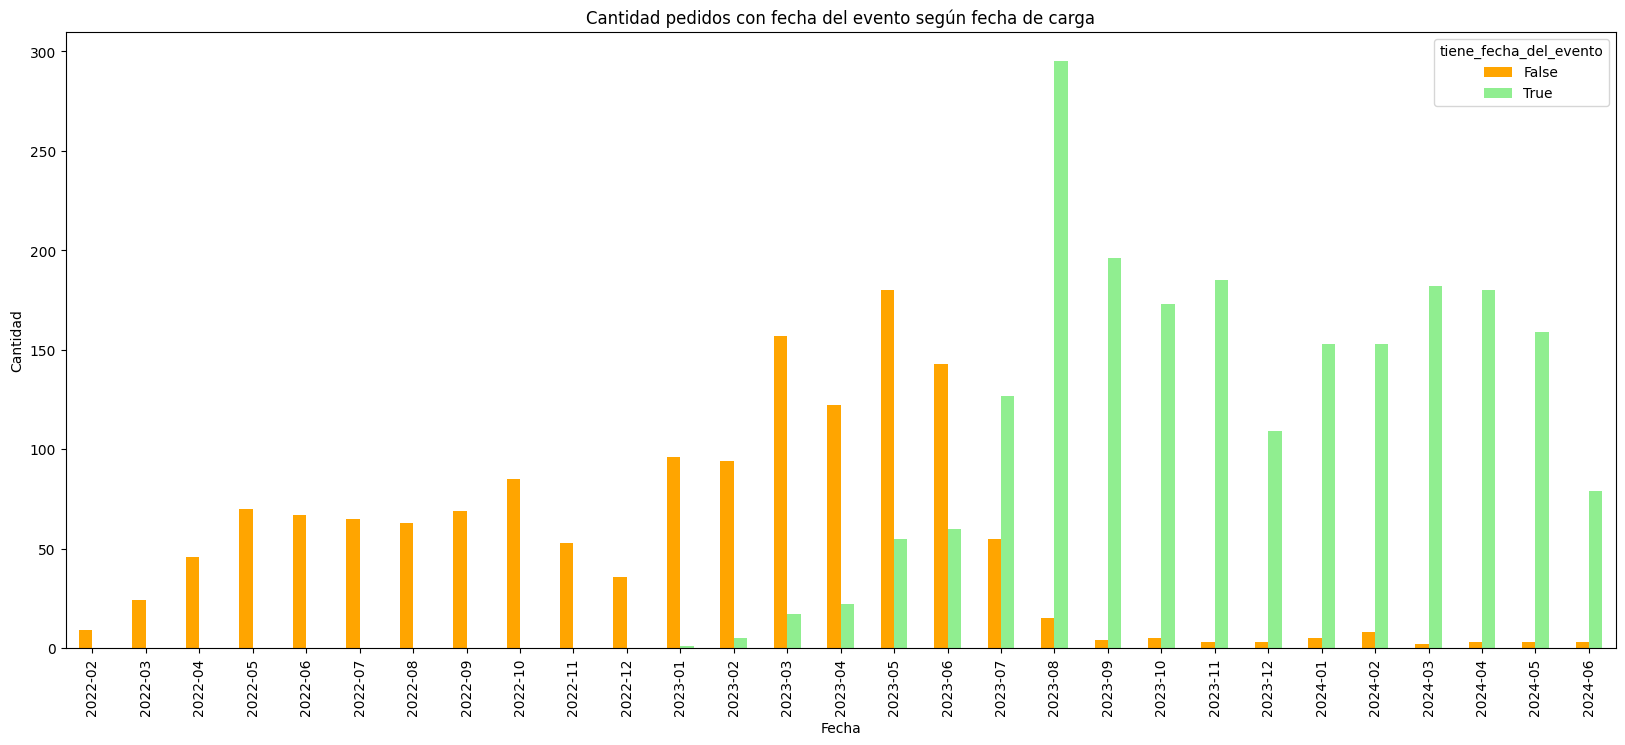

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(20,8))
df_pedidos_wc_sh[columns_to_convert].apply(pd.to_datetime,utc=True)
df_pedidos_con_o_sin_fecha_evento = df_pedidos_wc_sh.copy()
df_pedidos_con_o_sin_fecha_evento['tiene_fecha_del_evento'] = df_pedidos_con_o_sin_fecha_evento['Inicio_evento'].notna()

df_pedidos_con_o_sin_fecha_evento['mes'] = df_pedidos_con_o_sin_fecha_evento['date_created'].dt.to_period('M')

conteo_mes_estado_fecha = df_pedidos_con_o_sin_fecha_evento.groupby(['mes','tiene_fecha_del_evento']).size().unstack(fill_value=0)


# Graficar
conteo_mes_estado_fecha.plot(kind='bar',ax=ax,color=['orange','lightgreen'])
ax.set_title("Cantidad pedidos con fecha del evento según fecha de carga")
ax.set_xlabel("Fecha")
ax.set_ylabel("Cantidad")
plt.show()

### Conclusión faltantes de dato de fecha del evento
Podemos ver que los eventos cargados previo al 2023-08 tienen muchos eventos sin fecha del evento.
El sistema interno (App gestión interna​) comenzó a estar en funcionamiento durante ese mes. Y es a partir de esta fecha en la que casi todos los eventos tienen carga correspondiente.

Para obtener las fechas del evento vamos a realizar los siguientes filtros:
- Eventos donde no esté el dato de Inicio_evento
- Eventos donde hay una nota del cliente (customer note). En este campo podemos encontrar información de la fecha del evento

In [ ]:
df_pedidos_fecha_evento = df_pedidos_wc_sh[(df_pedidos_wc_sh['Inicio_evento'].isna())  & (df_pedidos_wc_sh['customer_note'].notna())]
df_pedidos_fecha_evento['customer_note']

Title
10112    Ruy (nombre de nene)\r\n.       Cuantos años c...
10060    az cumple 7 el 9 de agosto \r\nEmpieza a las 4...
9986     Rufina \r\nSábado 3/8\r\n3 años \r\n15 a 18 hs...
9733     Hola chicas! Les escribo para contarles que de...
9730     Olivia Aranda\r\n1er añito\r\nFecha el 16 de j...
                               ...                        
2704           Agregar panel lateral: tematica La sirenita
2635     Montaje infantil encanto con flores de globos ...
2573        Montaje infantil premium animales de la selva.
2563     temática elefante con globo aerostatico como e...
2492                                    la granja de zenon
Name: customer_note, Length: 1102, dtype: object

## Obtención de datos de fecha del customer note
Aplicamos regex para poder encontrar los datos de fecha.
- El patrón que se puede ver es:
    - 28 de junio ({nro_dia} de {nombre_mes})
    - 10/08/2024
    - 16 marzo ({nro_dia} {nombre_mes})
    - 26.11.23 ({nro_dia}.{nro_mes}.{nro_año})
    

In [ ]:
pattern = r'\b(\d{1,2} de [a-zA-Z]+(?!\s*HS)|\d{1,2}(?:/\d{1,2})?/\d{2,4}|\d{1,2}\.\d{1,2}\.\d{2,4})\b'
# Extraer fechas usando el patrón regex
df_pedidos_wc_sh['fecha'] = df_pedidos_wc_sh['customer_note'].str.extract(pattern)

In [ ]:
print(f"Fechas encontradas con regex: {df_pedidos_wc_sh['fecha'].notna().sum()}")
print(f"Fechas NO encontradas con regex: {df_pedidos_wc_sh['fecha'].isna().sum()}")

Fechas encontradas con regex: 1455
Fechas NO encontradas con regex: 2191


In [ ]:
def evaluar_fecha_correcta(data):
    try:
        return pd.to_datetime(data, errors='coerce')
    except:
        return pd.NaT

In [ ]:
df_pedidos_wc_sh['fecha_complete'] = df_pedidos_wc_sh['fecha'].apply(evaluar_fecha_correcta)

/tmp/ipykernel_222609/4075736083.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(data, errors='coerce')
/tmp/ipykernel_222609/4075736083.py:3: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(data, errors='coerce')


In [ ]:
df_pedidos_wc_sh['fecha_complete'].unique()

<DatetimeArray>
[                'NaT', '2024-08-24 00:00:00', '2024-10-08 00:00:00',
 '2024-07-23 00:00:00', '2024-07-14 00:00:00', '2024-03-08 00:00:00',
 '2024-08-17 00:00:00', '2024-07-27 00:00:00', '2024-06-30 00:00:00',
 '2024-06-07 00:00:00',
 ...
 '2022-11-06 00:00:00', '2022-05-06 00:00:00', '2022-04-06 00:00:00',
 '2022-10-07 00:00:00', '2022-04-19 00:00:00', '2022-05-22 00:00:00',
 '2022-05-25 00:00:00', '2022-08-05 00:00:00', '2022-08-14 00:00:00',
 '2022-09-07 00:00:00']
Length: 323, dtype: datetime64[ns]

Completamos la columnas inicio_evento con las fechas recuperadas

In [ ]:
df_pedidos_wc_sh.reset_index(drop=True, inplace=True)
df_pedidos_wc_sh.loc[df_pedidos_wc_sh['Inicio_evento'].isna(), 'Inicio_evento'] = df_pedidos_wc_sh['fecha_complete']

In [ ]:
missing_values_info(df_pedidos_wc_sh,'Inicio_evento')

Pedidos sin dato de fecha del evento -> 1229 de 3646 - (33.71 %)


In [ ]:
df_pedidos_wc_sh[df_pedidos_wc_sh['fecha_complete'].isna()]

,status,date_created,date_modified,payment_method,payment_method_title,created_via,customer_note,date_paid,date_created_gmt,date_modified_gmt,...,billing_lugar,Estado,Edad,Tematica,Fin_evento,Lugar,Created,Inicio_evento,fecha,fecha_complete
0,pending,2024-06-24 15:40:13+00:00,2024-06-24 15:42:18+00:00,NaN,NaN,admin,Ruy (nombre de nene)\r\n. Cuantos años c...,NaT,2024-06-24T15:40:13,2024-06-24T15:42:18,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT,28/09,NaT
1,pending,2024-06-24 15:28:51+00:00,2024-06-24 15:39:58+00:00,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas si...,checkout,NaN,NaT,2024-06-24T15:28:51,2024-06-24T15:39:58,...,Salón,NaN,NaN,NaN,NaT,NaN,NaT,2024-08-24 00:00:00+00:00,NaN,NaT
2,on-hold,2024-06-24 15:24:51+00:00,2024-06-24 15:24:51+00:00,bacs,Transferencia bancaria -20%,checkout,NaN,NaT,2024-06-24T15:24:51,2024-06-24T15:24:51,...,SUM,NaN,NaN,NaN,NaT,NaN,NaT,2024-06-30 00:00:00+00:00,NaN,NaT
3,cancelled,2024-06-24 15:24:27+00:00,2024-06-24 15:25:22+00:00,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas si...,checkout,NaN,NaT,2024-06-24T15:24:27,2024-06-24T15:25:22,...,Salón,NaN,NaN,NaN,NaT,NaN,NaT,2024-08-24 00:00:00+00:00,NaN,NaT
5,processing,2024-06-24 14:26:27+00:00,2024-06-24 14:28:17+00:00,NaN,NaN,admin,Polo\r\n2 años \r\n29 de junio de 2024\r\nInic...,2024-06-24 14:28:17+00:00,2024-06-24T14:26:27,2024-06-24T14:28:17,...,NaN,pendiente,0.0,NaN,NaT,NaN,2024-06-24 14:28:53+00:00,2024-06-24 14:26:27+00:00,29 de junio,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3641,completed,2022-02-22 13:32:40+00:00,2022-03-14 16:11:49+00:00,NaN,NaN,NaN,NaN,2022-02-22 13:35:02+00:00,2022-02-22T13:32:40,2022-03-14T16:11:49,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT,NaN,NaT
3642,completed,2022-02-16 13:59:53+00:00,2022-03-20 16:29:10+00:00,other,Otro,admin,la granja de zenon,2022-02-22 15:07:38+00:00,2022-02-16T13:59:53,2022-03-20T16:29:10,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT,NaN,NaT
3643,completed,2022-02-15 15:11:52+00:00,2022-02-22 13:34:14+00:00,other,Otro,admin,NaN,2022-02-22 13:34:14+00:00,2022-02-15T15:11:52,2022-02-22T13:34:14,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT,NaN,NaT
3644,completed,2022-02-11 16:55:21+00:00,2022-04-06 16:14:09+00:00,NaN,NaN,NaN,NaN,2022-02-11 17:14:17+00:00,2022-02-11T16:55:21,2022-04-06T16:14:09,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT,NaN,NaT


### Convertimos en inglés las fechas para poder agregarle el año

In [ ]:
def convertir_fecha(fecha):
    meses = {
        'enero': 'jan', 'febrero': 'feb', 'marzo': 'mar', 'abril': 'apr',
        'mayo': 'May', 'junio': 'jun', 'julio': 'Jul', 'agosto': 'aug',
        'septiembre': 'sep', 'octubre': 'oct', 'noviembre': 'Nov', 'diciembre': 'dec'
    }

    try:
        fecha = fecha.lower()
        dia, de, mes = fecha.split()
        if de=='de':
            mes_ingles = meses[mes]

            fecha_ingles = f"{mes_ingles} {dia}"

            return fecha_ingles


        else:
            return fecha
    except:
        return fecha

In [ ]:
df_pedidos_wc_sh['fecha'] = df_pedidos_wc_sh['fecha'].apply(convertir_fecha)

## Funcion que agrega el año

- Hay dos formas:
    - {nro_mes} / {nro_anio}
    - {name_mes} {nro_dia}

In [ ]:
def agregar_ultimo_caracter(data):
    try:
        if "/" in data:
            return data + "/"
        else:
            return data + " "
    except:
        return data

In [ ]:
df_pedidos_wc_sh['fecha'] = df_pedidos_wc_sh['fecha'].apply(agregar_ultimo_caracter)

In [ ]:
df_pedidos_wc_sh['anio_evento_temp'] = (df_pedidos_wc_sh['date_created'].dt.year).astype(str)
df_pedidos_wc_sh['fecha'] = df_pedidos_wc_sh['fecha'].str.cat(df_pedidos_wc_sh['anio_evento_temp'], sep='')

df_pedidos_wc_sh

,status,date_created,date_modified,payment_method,payment_method_title,created_via,customer_note,date_paid,date_created_gmt,date_modified_gmt,...,Estado,Edad,Tematica,Fin_evento,Lugar,Created,Inicio_evento,fecha,fecha_complete,anio_evento_temp
0,pending,2024-06-24 15:40:13+00:00,2024-06-24 15:42:18+00:00,NaN,NaN,admin,Ruy (nombre de nene)\r\n. Cuantos años c...,NaT,2024-06-24T15:40:13,2024-06-24T15:42:18,...,NaN,NaN,NaN,NaT,NaN,NaT,NaT,28/09/2024,NaT,2024
1,pending,2024-06-24 15:28:51+00:00,2024-06-24 15:39:58+00:00,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas si...,checkout,NaN,NaT,2024-06-24T15:28:51,2024-06-24T15:39:58,...,NaN,NaN,NaN,NaT,NaN,NaT,2024-08-24 00:00:00+00:00,NaN,NaT,2024
2,on-hold,2024-06-24 15:24:51+00:00,2024-06-24 15:24:51+00:00,bacs,Transferencia bancaria -20%,checkout,NaN,NaT,2024-06-24T15:24:51,2024-06-24T15:24:51,...,NaN,NaN,NaN,NaT,NaN,NaT,2024-06-30 00:00:00+00:00,NaN,NaT,2024
3,cancelled,2024-06-24 15:24:27+00:00,2024-06-24 15:25:22+00:00,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas si...,checkout,NaN,NaT,2024-06-24T15:24:27,2024-06-24T15:25:22,...,NaN,NaN,NaN,NaT,NaN,NaT,2024-08-24 00:00:00+00:00,NaN,NaT,2024
4,processing,2024-06-24 14:32:27+00:00,2024-06-24 14:52:28+00:00,NaN,NaN,admin,Nombre de del homenajeado/a: Bautista\r\n. ...,2024-06-24 14:52:28+00:00,2024-06-24T14:32:27,2024-06-24T14:52:28,...,pendiente,0.0,NaN,NaT,NaN,2024-06-24 14:55:09+00:00,2024-06-24 14:32:27+00:00,24/08/2024/2024,2024-08-24,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3641,completed,2022-02-22 13:32:40+00:00,2022-03-14 16:11:49+00:00,NaN,NaN,NaN,NaN,2022-02-22 13:35:02+00:00,2022-02-22T13:32:40,2022-03-14T16:11:49,...,NaN,NaN,NaN,NaT,NaN,NaT,NaT,NaN,NaT,2022
3642,completed,2022-02-16 13:59:53+00:00,2022-03-20 16:29:10+00:00,other,Otro,admin,la granja de zenon,2022-02-22 15:07:38+00:00,2022-02-16T13:59:53,2022-03-20T16:29:10,...,NaN,NaN,NaN,NaT,NaN,NaT,NaT,NaN,NaT,2022
3643,completed,2022-02-15 15:11:52+00:00,2022-02-22 13:34:14+00:00,other,Otro,admin,NaN,2022-02-22 13:34:14+00:00,2022-02-15T15:11:52,2022-02-22T13:34:14,...,NaN,NaN,NaN,NaT,NaN,NaT,NaT,NaN,NaT,2022
3644,completed,2022-02-11 16:55:21+00:00,2022-04-06 16:14:09+00:00,NaN,NaN,NaN,NaN,2022-02-11 17:14:17+00:00,2022-02-11T16:55:21,2022-04-06T16:14:09,...,NaN,NaN,NaN,NaT,NaN,NaT,NaT,NaN,NaT,2022


In [ ]:
df_pedidos_wc_sh['fecha_complete'] = df_pedidos_wc_sh['fecha'].apply(evaluar_fecha_correcta)

/tmp/ipykernel_222609/4075736083.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(data, errors='coerce')
/tmp/ipykernel_222609/4075736083.py:3: UserWarning: Parsing dates in %d/%m/%H%M/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(data, errors='coerce')
/tmp/ipykernel_222609/4075736083.py:3: UserWarning: Parsing dates in %d.%m.%H%M %Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(data, errors='coerce')
/tmp/ipykernel_222609/4075736083.py:3: UserWarning: Parsing dates in %d/%m/%Y/%H%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(data, errors='coerce

In [ ]:
missing_values_info(df_pedidos_wc_sh,'Inicio_evento')

Pedidos sin dato de fecha del evento -> 840 de 3646 - (23.04 %)


In [ ]:
df_pedidos_wc_sh.reset_index(drop=True, inplace=True)
df_pedidos_wc_sh.loc[df_pedidos_wc_sh['Inicio_evento'].isna(), 'Inicio_evento'] = df_pedidos_wc_sh['fecha_complete']

Tratamos de ver que datos aún nos quedaron como faltantes y los evaluamos manualmente si son pocos, o automáticamente si vemos un patrón

In [ ]:
pd.set_option('display.max_colwidth', 500)
df_pedidos_wc_sh['customer_note'][(df_pedidos_wc_sh['Inicio_evento'].isna()) & (df_pedidos_wc_sh['fecha'].isna()) & (df_pedidos_wc_sh['customer_note'].notna())]
#df_pedidos_wc_sh[(df_pedidos_wc_sh['Inicio_evento'].isna()) & (df_pedidos_wc_sh['fecha'].isna())]


65                                                                                                                                                                                                                                                                      Rufina \r\nSábado 3/8\r\n3 años \r\n15 a 18 hs. \r\nSum (el cantón, Escobar) \r\nPepa pig \r\nCreo que el de paneles plus
173                                                                  Hola chicas! Les escribo para contarles que debemos pasar el curso ya que Noe está con fiebre y sin vos 😞 \nSeguro durante el día les escriba por WhatsApp. \nEstamos reorganizando con el lugar para posible fecha la semana próxima. Apenas nos confirmen les aviso! \nLes piso disculpas! \n\nMile - Ambientando fiestas 
704                                                                Rocío y Alejandro\r\n.       Cuantos años cumple:\r\nCasamiento\r\n•\tFecha\r\nViernes 23/2\r\n•\tHora de inicio\r\n10:30\r\n. Hora de finalización\r\n18:30\r\n.

Podemos ver que hay mas pedidos que se pueden recuperar. Por ahora nos quedamos con los que tenemos

/tmp/ipykernel_222609/2265077564.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_pedidos_con_o_sin_fecha_evento['mes'] = df_pedidos_con_o_sin_fecha_evento['date_created'].dt.to_period('M')


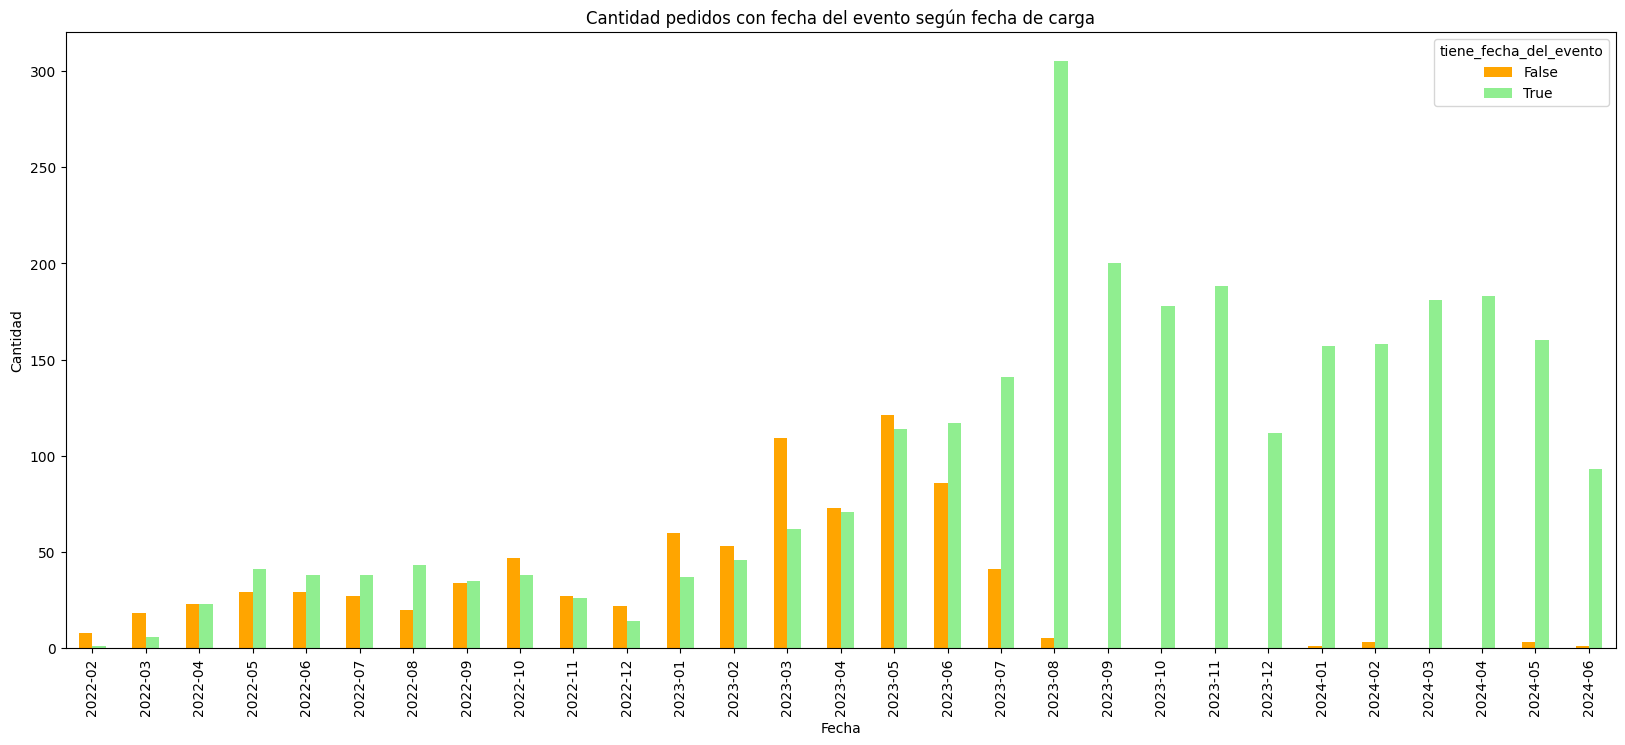

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(20,8))
df_pedidos_wc_sh[columns_to_convert].apply(pd.to_datetime,utc=True)
df_pedidos_con_o_sin_fecha_evento = df_pedidos_wc_sh.copy()
df_pedidos_con_o_sin_fecha_evento['tiene_fecha_del_evento'] = df_pedidos_con_o_sin_fecha_evento['Inicio_evento'].notna()

df_pedidos_con_o_sin_fecha_evento['mes'] = df_pedidos_con_o_sin_fecha_evento['date_created'].dt.to_period('M')

conteo_mes_estado_fecha = df_pedidos_con_o_sin_fecha_evento.groupby(['mes','tiene_fecha_del_evento']).size().unstack(fill_value=0)


# Graficar
conteo_mes_estado_fecha.plot(kind='bar',ax=ax,color=['orange','lightgreen'])
ax.set_title("Cantidad pedidos con fecha del evento según fecha de carga")
ax.set_xlabel("Fecha")
ax.set_ylabel("Cantidad")
plt.show()

## 1) ¿Cuánto tiempo antes reserva la gente al día del evento?
Calculamos para todos los eventos donde hay dato del inicio del evento


In [ ]:
df_pedidos_wc_sh =  df_pedidos_wc_sh[df_pedidos_wc_sh['Inicio_evento'].notna()]
df_pedidos_wc_sh =  df_pedidos_wc_sh[df_pedidos_wc_sh['Inicio_evento']!=df_pedidos_wc_sh['date_created']]

In [ ]:
df_pedidos_wc_sh[['Inicio_evento','date_created']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2783 entries, 0 to 3640
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   Inicio_evento  2783 non-null   object             
 1   date_created   2783 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 65.2+ KB


Convertimos los campos al mismo tipo

In [ ]:
def safe_convert_to_datetime(value):
    try:
        return pd.to_datetime(value, utc=True)
    except Exception:
        return value

In [ ]:
df_pedidos_wc_sh[['Inicio_evento','date_created']]

,Inicio_evento,date_created
0,2024-09-28 00:00:00,2024-06-24 15:40:13+00:00
1,2024-08-24 00:00:00+00:00,2024-06-24 15:28:51+00:00
2,2024-06-30 00:00:00+00:00,2024-06-24 15:24:51+00:00
3,2024-08-24 00:00:00+00:00,2024-06-24 15:24:27+00:00
17,2025-02-15 00:00:00+00:00,2024-06-24 01:21:50+00:00
...,...,...
3618,2022-05-09 00:00:00,2022-03-29 16:28:50+00:00
3623,2022-07-08 00:00:00,2022-03-27 17:33:47+00:00
3632,2022-06-18 00:00:00,2022-03-21 14:34:14+00:00
3635,2022-04-24 00:00:00,2022-03-11 14:11:45+00:00


In [ ]:
df_pedidos_wc_sh['Inicio_evento'] =  df_pedidos_wc_sh['Inicio_evento'].apply(safe_convert_to_datetime)

In [ ]:
df_pedidos_wc_sh[['Inicio_evento','date_created']]

,Inicio_evento,date_created
0,2024-09-28 00:00:00+00:00,2024-06-24 15:40:13+00:00
1,2024-08-24 00:00:00+00:00,2024-06-24 15:28:51+00:00
2,2024-06-30 00:00:00+00:00,2024-06-24 15:24:51+00:00
3,2024-08-24 00:00:00+00:00,2024-06-24 15:24:27+00:00
17,2025-02-15 00:00:00+00:00,2024-06-24 01:21:50+00:00
...,...,...
3618,2022-05-09 00:00:00+00:00,2022-03-29 16:28:50+00:00
3623,2022-07-08 00:00:00+00:00,2022-03-27 17:33:47+00:00
3632,2022-06-18 00:00:00+00:00,2022-03-21 14:34:14+00:00
3635,2022-04-24 00:00:00+00:00,2022-03-11 14:11:45+00:00


### Calculo del tiempo de anticipación de reserva de un evento

In [ ]:
df_pedidos_wc_sh['anticipacion_reserva_dias'] = (df_pedidos_wc_sh['Inicio_evento'] -df_pedidos_wc_sh['date_created']).dt.days

## Verificación de datos outliers

In [ ]:
df_pedidos_wc_sh

,status,date_created,date_modified,payment_method,payment_method_title,created_via,customer_note,date_paid,date_created_gmt,date_modified_gmt,...,Edad,Tematica,Fin_evento,Lugar,Created,Inicio_evento,fecha,fecha_complete,anio_evento_temp,anticipacion_reserva_dias
0,pending,2024-06-24 15:40:13+00:00,2024-06-24 15:42:18+00:00,NaN,NaN,admin,Ruy (nombre de nene)\r\n. Cuantos años cumple: 1\r\n•\tFecha sábado 28/09 \r\n•\tHora de inicio 13hs\r\n. Hora de finalización 16hs\r\n. Dirección del lugar: Bartolomé Mitre 3925\r\n. Es SUM.\r\n•\tBaby Yoda con colores pasteles \r\nQué servicio queres: Decoración con 3 paneles gold con pastelería.(con transferencia )\r\nMÁS PELOTERO (6 cuotas),NaT,2024-06-24T15:40:13,2024-06-24T15:42:18,...,NaN,NaN,NaT,NaN,NaT,2024-09-28 00:00:00+00:00,28/09/2024,2024-09-28,2024,95
1,pending,2024-06-24 15:28:51+00:00,2024-06-24 15:39:58+00:00,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas sin interés,checkout,NaN,NaT,2024-06-24T15:28:51,2024-06-24T15:39:58,...,NaN,NaN,NaT,NaN,NaT,2024-08-24 00:00:00+00:00,NaN,NaT,2024,60
2,on-hold,2024-06-24 15:24:51+00:00,2024-06-24 15:24:51+00:00,bacs,Transferencia bancaria -20%,checkout,NaN,NaT,2024-06-24T15:24:51,2024-06-24T15:24:51,...,NaN,NaN,NaT,NaN,NaT,2024-06-30 00:00:00+00:00,NaN,NaT,2024,5
3,cancelled,2024-06-24 15:24:27+00:00,2024-06-24 15:25:22+00:00,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas sin interés,checkout,NaN,NaT,2024-06-24T15:24:27,2024-06-24T15:25:22,...,NaN,NaN,NaT,NaN,NaT,2024-08-24 00:00:00+00:00,NaN,NaT,2024,60
17,processing,2024-06-24 01:21:50+00:00,2024-06-24 01:22:31+00:00,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas sin interés,checkout,NaN,2024-06-24 01:22:31+00:00,2024-06-24T01:21:50,2024-06-24T01:22:31,...,5.0,A confirmar,2025-02-15 23:30:00+00:00,Salón,2024-06-24 01:23:15+00:00,2025-02-15 00:00:00+00:00,NaN,NaT,2024,235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3618,completed,2022-03-29 16:28:50+00:00,2022-07-18 18:52:18+00:00,NaN,NaN,admin,9 de mayo\r\ntemática unicornio\r\ntranfirio el 50% 18.0000\r\nAgregamos en nombre en polifan MIA,2022-03-29 16:49:32+00:00,2022-03-29T16:28:50,2022-07-18T18:52:18,...,NaN,NaN,NaT,NaN,NaT,2022-05-09 00:00:00+00:00,May 9 2022,2022-05-09,2022,40
3623,confirmado,2022-03-27 17:33:47+00:00,2022-07-26 18:38:32+00:00,NaN,NaN,NaN,"guirnalda con globos piñata\r\n7/8 \r\nTemática Blue \r\ncambie el horario del cumpleaños y la fecha, va a ser el sábado 07/08 a las 10:hs en salón\r\n\r\nQuería sumarle el arreglo floral que viene por dos y dos columnas de globos acordé a la temática de las pistas de Blue y tu.",2022-03-28 20:11:16+00:00,2022-03-27T17:33:47,2022-07-26T18:38:32,...,NaN,NaN,NaT,NaN,NaT,2022-07-08 00:00:00+00:00,07/08/2022,2022-07-08,2022,102
3632,refunded,2022-03-21 14:34:14+00:00,2022-07-22 14:20:20+00:00,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas sin interés,checkout,Cambio de lugar y horario:\r\n18 de junio\r\nSalon Zazu\r\ncumple.comienza a las 17.30\r\n Colombres 873,2022-03-21 14:37:51+00:00,2022-03-21T14:34:14,2022-07-22T14:20:20,...,NaN,NaN,NaT,NaN,NaT,2022-06-18 00:00:00+00:00,jun 18 2022,2022-06-18,2022,88
3635,completed,2022-03-11 14:11:45+00:00,2022-04-25 21:53:27+00:00,woo-mercado-pago-custom,Paga con tarjetas de débito y crédito,admin,Montaje infantil encanto con flores de globos 13 hs \r\nagregar funda de mesa personalizada con nombre Valentina \r\n24 de abril,2022-03-10 14:15:35+00:00,2022-03-11T14:11:45,2022-04-25T21:53:27,...,NaN,NaN,NaT,NaN,NaT,2022-04-24 00:00:00+00:00,apr 24 2022,2022-04-24,2022,43


## Box plot Anticipación de reserva de pedidos

Text(0.5, 0, 'Días de anticipación')

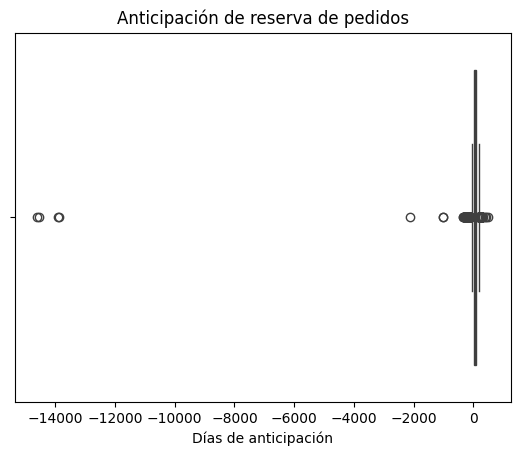

In [ ]:
sns.boxplot(x=df_pedidos_wc_sh['anticipacion_reserva_dias'])
plt.title('Anticipación de reserva de pedidos')
plt.xlabel('Días de anticipación')

Claramente tenemos outliers, ya que no puede haber un evento que suceda previo a su reserva.

Vamos a ver cuantos datos son

In [ ]:
df_pedidos_wc_sh

,status,date_created,date_modified,payment_method,payment_method_title,created_via,customer_note,date_paid,date_created_gmt,date_modified_gmt,...,Edad,Tematica,Fin_evento,Lugar,Created,Inicio_evento,fecha,fecha_complete,anio_evento_temp,anticipacion_reserva_dias
0,pending,2024-06-24 15:40:13+00:00,2024-06-24 15:42:18+00:00,NaN,NaN,admin,Ruy (nombre de nene)\r\n. Cuantos años cumple: 1\r\n•\tFecha sábado 28/09 \r\n•\tHora de inicio 13hs\r\n. Hora de finalización 16hs\r\n. Dirección del lugar: Bartolomé Mitre 3925\r\n. Es SUM.\r\n•\tBaby Yoda con colores pasteles \r\nQué servicio queres: Decoración con 3 paneles gold con pastelería.(con transferencia )\r\nMÁS PELOTERO (6 cuotas),NaT,2024-06-24T15:40:13,2024-06-24T15:42:18,...,NaN,NaN,NaT,NaN,NaT,2024-09-28 00:00:00+00:00,28/09/2024,2024-09-28,2024,95
1,pending,2024-06-24 15:28:51+00:00,2024-06-24 15:39:58+00:00,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas sin interés,checkout,NaN,NaT,2024-06-24T15:28:51,2024-06-24T15:39:58,...,NaN,NaN,NaT,NaN,NaT,2024-08-24 00:00:00+00:00,NaN,NaT,2024,60
2,on-hold,2024-06-24 15:24:51+00:00,2024-06-24 15:24:51+00:00,bacs,Transferencia bancaria -20%,checkout,NaN,NaT,2024-06-24T15:24:51,2024-06-24T15:24:51,...,NaN,NaN,NaT,NaN,NaT,2024-06-30 00:00:00+00:00,NaN,NaT,2024,5
3,cancelled,2024-06-24 15:24:27+00:00,2024-06-24 15:25:22+00:00,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas sin interés,checkout,NaN,NaT,2024-06-24T15:24:27,2024-06-24T15:25:22,...,NaN,NaN,NaT,NaN,NaT,2024-08-24 00:00:00+00:00,NaN,NaT,2024,60
17,processing,2024-06-24 01:21:50+00:00,2024-06-24 01:22:31+00:00,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas sin interés,checkout,NaN,2024-06-24 01:22:31+00:00,2024-06-24T01:21:50,2024-06-24T01:22:31,...,5.0,A confirmar,2025-02-15 23:30:00+00:00,Salón,2024-06-24 01:23:15+00:00,2025-02-15 00:00:00+00:00,NaN,NaT,2024,235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3618,completed,2022-03-29 16:28:50+00:00,2022-07-18 18:52:18+00:00,NaN,NaN,admin,9 de mayo\r\ntemática unicornio\r\ntranfirio el 50% 18.0000\r\nAgregamos en nombre en polifan MIA,2022-03-29 16:49:32+00:00,2022-03-29T16:28:50,2022-07-18T18:52:18,...,NaN,NaN,NaT,NaN,NaT,2022-05-09 00:00:00+00:00,May 9 2022,2022-05-09,2022,40
3623,confirmado,2022-03-27 17:33:47+00:00,2022-07-26 18:38:32+00:00,NaN,NaN,NaN,"guirnalda con globos piñata\r\n7/8 \r\nTemática Blue \r\ncambie el horario del cumpleaños y la fecha, va a ser el sábado 07/08 a las 10:hs en salón\r\n\r\nQuería sumarle el arreglo floral que viene por dos y dos columnas de globos acordé a la temática de las pistas de Blue y tu.",2022-03-28 20:11:16+00:00,2022-03-27T17:33:47,2022-07-26T18:38:32,...,NaN,NaN,NaT,NaN,NaT,2022-07-08 00:00:00+00:00,07/08/2022,2022-07-08,2022,102
3632,refunded,2022-03-21 14:34:14+00:00,2022-07-22 14:20:20+00:00,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas sin interés,checkout,Cambio de lugar y horario:\r\n18 de junio\r\nSalon Zazu\r\ncumple.comienza a las 17.30\r\n Colombres 873,2022-03-21 14:37:51+00:00,2022-03-21T14:34:14,2022-07-22T14:20:20,...,NaN,NaN,NaT,NaN,NaT,2022-06-18 00:00:00+00:00,jun 18 2022,2022-06-18,2022,88
3635,completed,2022-03-11 14:11:45+00:00,2022-04-25 21:53:27+00:00,woo-mercado-pago-custom,Paga con tarjetas de débito y crédito,admin,Montaje infantil encanto con flores de globos 13 hs \r\nagregar funda de mesa personalizada con nombre Valentina \r\n24 de abril,2022-03-10 14:15:35+00:00,2022-03-11T14:11:45,2022-04-25T21:53:27,...,NaN,NaN,NaT,NaN,NaT,2022-04-24 00:00:00+00:00,apr 24 2022,2022-04-24,2022,43


In [ ]:
pedidos_mal_fecha = df_pedidos_wc_sh[df_pedidos_wc_sh['anticipacion_reserva_dias']<=0]['date_created'].count()
print("Cantidad de pedidos donde sucedió el evento antes de la reserva (mal cargados):", pedidos_mal_fecha)

Cantidad de pedidos donde sucedió el evento antes de la reserva (mal cargados): 121


In [ ]:
df_pedidos_wc_sh = df_pedidos_wc_sh[df_pedidos_wc_sh['anticipacion_reserva_dias']>0]

Text(0.5, 0, 'Días de anticipación')

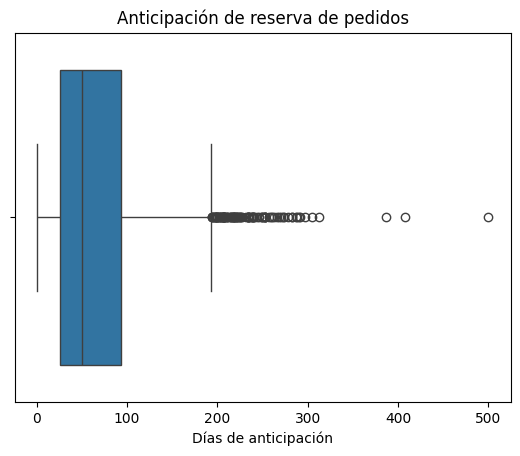

In [ ]:
sns.boxplot(x=df_pedidos_wc_sh['anticipacion_reserva_dias'])
plt.title('Anticipación de reserva de pedidos')
plt.xlabel('Días de anticipación')

Por otro lado vamos a eliminar al outlier de apróximadamente 500 días independientemente de si está bien o mal cargado. Solo por el concepto de ser un outlier

In [ ]:
df_pedidos_wc_sh = df_pedidos_wc_sh[df_pedidos_wc_sh['anticipacion_reserva_dias']<400]

Text(0.5, 0, 'Días de anticipación')

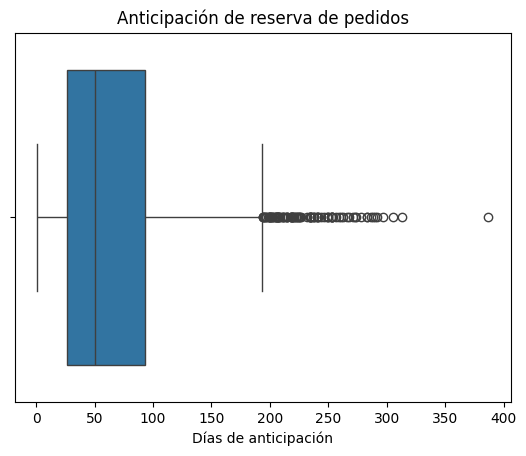

In [ ]:
sns.boxplot(x=df_pedidos_wc_sh['anticipacion_reserva_dias'])
plt.title('Anticipación de reserva de pedidos')
plt.xlabel('Días de anticipación')

## Resultado: ¿Cuánto tiempo antes al día del evento reserva la gente?​

In [ ]:
df_pedidos_wc_sh['anticipacion_reserva_dias'].mean()

66.9890977443609

Ahora podemos graficar con un histograma la distribución de días de anticipación de reserva de un evento

Text(0, 0.5, 'Frecuencia')

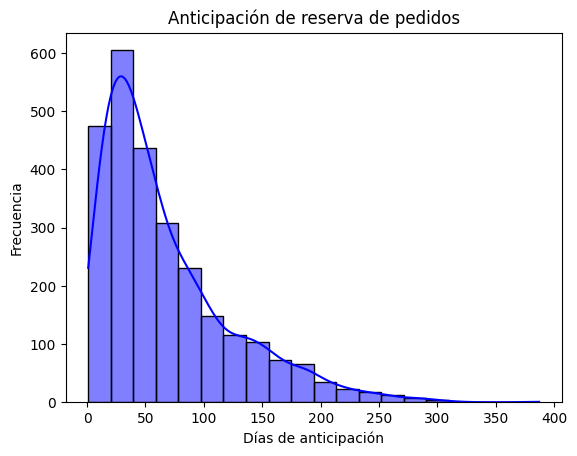

In [ ]:
sns.histplot(df_pedidos_wc_sh['anticipacion_reserva_dias'], kde=True, color='blue', bins=20)

plt.title('Anticipación de reserva de pedidos')
plt.xlabel('Días de anticipación')
plt.ylabel('Frecuencia')